In [1]:
import pandas as pd 
df_train = {}
for i in range(1,7):
    df_train[i] = pd.read_excel(f"./dataset/SDG_Dataset_Split/SDG_Dataset_Split_4/learner-{i}.xlsx")

In [2]:
def transfer(text):
    if text == 4:  # 1: target
        return 1
    else:         # 0: other sdg
        return 0

In [3]:
import numpy as np
for i in range(1, 7):
    df_train[i]["sdg"] = df_train[i]["sdg"].apply(lambda x: transfer(x))
    df_train[i] = df_train[i].sample(frac=1).reset_index(drop=True)

In [4]:
import nltk
from nltk import pos_tag
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import re
import json 

In [5]:
test = pd.read_csv("./dataset/SDG_Dataset_Split/test.csv")
X_test = test["sample"]
test["sdg"] = test["sdg"].apply(lambda x: transfer(x))
Y_test = test["sdg"]
predictions_1 = []

In [6]:
def model_1(df_train, df_test):
    # LSTM建模
    # 设置最频繁使用的50000个词(在texts_to_matrix是会取前MAX_NB_WORDS,会取前MAX_NB_WORDS列)
    MAX_NB_WORDS = 5000
    # 每条cut_review最大的长度
    MAX_SEQUENCE_LENGTH = 100
    # 设置Embedding层的维度
    EMBEDDING_DIM = 100
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df_train['sample'].values)
    word_index = tokenizer.word_index
    print('共有 %s 个不相同的词语.' % len(word_index))
    X_train = tokenizer.texts_to_sequences(df_train['sample'].values)
    X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
    
    Y_train = pd.get_dummies(df_train['sdg']).values
    
    X_test = tokenizer.texts_to_sequences(df_test["sample"].values)
    X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
    
    Y_test = pd.get_dummies(df_test["sdg"]).values
    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.1))
    model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    epochs = 8
    batch_size = 64
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

    accr = model.evaluate(X_test, Y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))
    print("acc:", accr[1])
    
    y_pred = model.predict(X_test)
    predictions_1.append(y_pred)
    y_pred = y_pred.argmax(axis=1)
    Y_test = Y_test.argmax(axis=1)

In [7]:
for i in range(1, 7):
    model_1(df_train[i], test)

共有 7805 个不相同的词语.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 530,302
Trainable params: 530,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
45/45 [==============================] - 9s 131ms/step - loss: 0.5089 - accuracy: 0.

 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 2)                 102       
                                                                 
Total params: 530,302
Trainable params: 530,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
45/45 [==============================] - 8s 129ms/step - loss: 0.4403 - accuracy: 0.8329 - val_loss: 0.1150 - val_accuracy: 0.9683
Epoch 2/8
45/45 [==============================] - 5s 121ms/step - loss: 0.0790 - accuracy: 0.9769 - val_loss: 0.0809 - val_accuracy: 0.9743
Epoch 3/8
45/45 [==============================] - 4s 96ms/step - loss: 0.0314 - accuracy: 0.9927 - val_loss: 0.0795 - val_accuracy: 0.9703
Epoch 4/8
45/45 [======================

In [8]:
for i in range(6):
    for j in range(len(predictions_1[0])):
        if predictions_1[i][j][0] >= predictions_1[i][j][1]:
            predictions_1[i][j][0] = 1
            predictions_1[i][j][1] = 0
        else:
            predictions_1[i][j][0] = 0
            predictions_1[i][j][1] = 1 
prediction = predictions_1[0]
Y_test = pd.get_dummies(test["sdg"]).values
for j in range(len(predictions_1[0])):
    sum1 = 0
    sum2 = 0
    for i in range(6):
        sum1 += predictions_1[i][j][0]
        sum2 += predictions_1[i][j][1]
        if sum1 >= sum2:
            prediction[j][0] = 1
            prediction[j][1] = 0
        else:
            prediction[j][0] = 0
            prediction[j][1] = 1 

In [9]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('accuracy %s' % accuracy_score(prediction, Y_test))
print(classification_report(Y_test, prediction, zero_division=0))

accuracy 0.9742995169082126
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4480
           1       0.85      0.98      0.91       695

   micro avg       0.97      0.97      0.97      5175
   macro avg       0.92      0.98      0.95      5175
weighted avg       0.98      0.97      0.98      5175
 samples avg       0.97      0.97      0.97      5175



In [10]:
from sklearn.metrics import confusion_matrix
Y_test_list = []
for i in range(len(Y_test)):
    if Y_test[i][0] == 1:
        Y_test_list.append(0)
    else:
        Y_test_list.append(1)
Y_pre_list = []
for i in range(len(prediction)):
    if prediction[i][0] == 1:
        Y_pre_list.append(0)
    else:
        Y_pre_list.append(1)
confusion_matrix(Y_test_list, Y_pre_list)

array([[4361,  119],
       [  14,  681]])

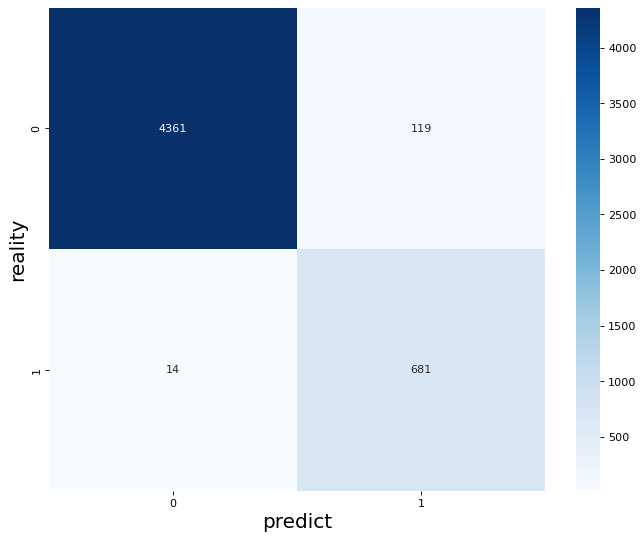

In [11]:
import matplotlib.pyplot as plt 
#生成混淆矩阵
conf_mat = confusion_matrix(Y_test_list, Y_pre_list)
fig, ax = plt.subplots(figsize=(10,8), dpi=80)
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=range(0,2), yticklabels=range(0,2), cmap="Blues")
plt.ylabel('reality',fontsize=18)
plt.xlabel('predict',fontsize=18)
plt.show()